In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Found 7995 images belonging to 2 classes.


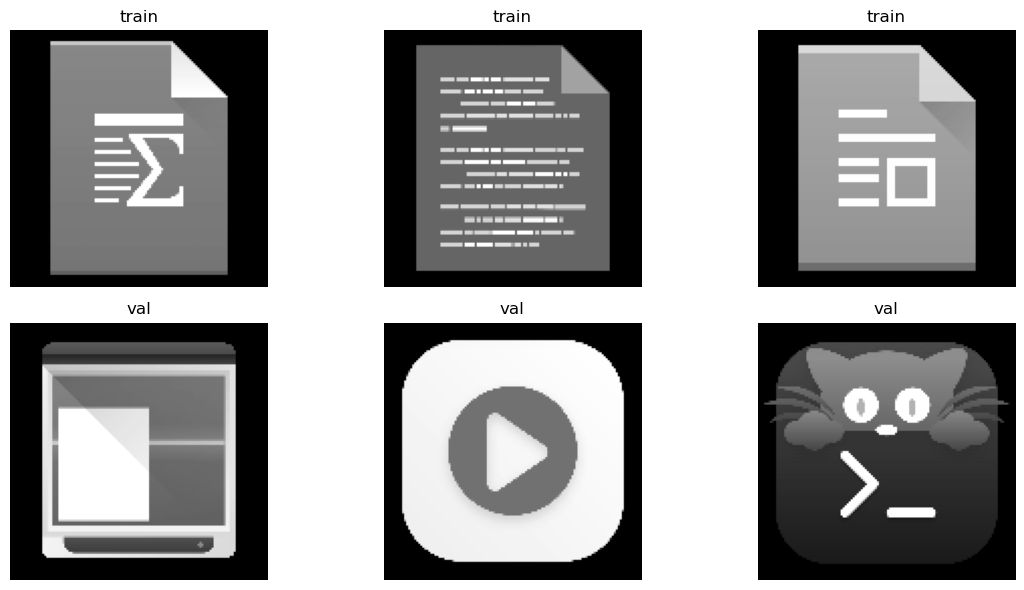

In [3]:
#Display some images

def display_samples(data_dir, target_size=(128, 128), batch_size=32, num_samples=3):
    # Create an ImageDataGenerator to load images
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',  # or 'categorical' based on your labels
        color_mode='grayscale',  # Assuming grayscale images
        shuffle=True
    )
    
    # Create a figure to display the images
    plt.figure(figsize=(12, 6))
    
    class_labels = {v: k for k, v in generator.class_indices.items()}
    
    for class_idx, class_name in class_labels.items():
        # Get images and labels
        X_batch, y_batch = next(generator)
        
        # Find the indices of the samples from this class
        class_indices = [i for i in range(len(y_batch)) if y_batch[i] == class_idx]
        
        # Display samples
        for i in range(min(num_samples, len(class_indices))):
            plt.subplot(2, num_samples, class_idx * num_samples + i + 1)
            plt.imshow(X_batch[class_indices[i]].squeeze(), cmap='gray')
            plt.title(f"{class_name}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Directory path
data_dir = r'C:\Users\Boluwatife\Steganalysis\dataset'  # Replace with your dataset path

# Display samples
display_samples(data_dir)


In [8]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,                  # Normalize pixel values to [0, 1]
    rotation_range=30,               # Random rotations
    width_shift_range=0.2,           # Horizontal shifts
    height_shift_range=0.2,          # Vertical shifts
    shear_range=0.2,                 # Shear transformations
    zoom_range=0.2,                  # Zoom-in/out
    horizontal_flip=True             # Flip images horizontally
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define directories
train_dir = r'C:\Users\Boluwatife\Steganalysis\dataset\train'
val_dir = r'C:\Users\Boluwatife\Steganalysis\dataset\val'

# Load training images from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),  # Resize all images to 256x256 for SRNet
    batch_size=32,
    class_mode='binary',     # Binary classification (stego vs clean)
    color_mode='grayscale'   # Use grayscale for SRNet
)

# Load validation images from directory
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

Found 6396 images belonging to 2 classes.
Found 1599 images belonging to 2 classes.


In [ ]:
def build_srnet(input_shape=(256, 256, 1)):
    model = models.Sequential()

    # Add an explicit Input layer
    model.add(layers.Input(shape=input_shape))

    # Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 4
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.GlobalAveragePooling2D())

    # Dense Layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    # Output Layer (Binary classification for steganalysis)
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Example usage
input_shape = (256, 256, 1)  # Assuming grayscale images of size 256x256
model = build_srnet(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

In [6]:
# Define image size and batch size
img_height, img_width = 256, 256
batch_size = 32  # Make sure to define batch_size

In [5]:
# Train the model using fit_generator
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/30


C:\Users\Boluwatife\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


199/199 ━━━━━━━━━━━━━━━━━━━━ 1783s 9s/step - accuracy: 0.4962 - loss: 0.9438 - val_accuracy: 0.4981 - val_loss: 0.6969
Epoch 2/30
  1/199 ━━━━━━━━━━━━━━━━━━━━ 19:02 6s/step - accuracy: 0.5938 - loss: 0.7043

C:\Users\Boluwatife\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5938 - loss: 0.7043 - val_accuracy: 0.5161 - val_loss: 0.6986
Epoch 3/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 1314s 7s/step - accuracy: 0.5012 - loss: 0.8090 - val_accuracy: 0.4821 - val_loss: 0.7325
Epoch 4/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5000 - loss: 0.7316 - val_accuracy: 0.6452 - val_loss: 0.6291
Epoch 5/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 1223s 6s/step - accuracy: 0.4951 - loss: 0.7599 - val_accuracy: 0.4949 - val_loss: 0.7018
Epoch 6/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4688 - loss: 0.7224 - val_accuracy: 0.5484 - val_loss: 0.6895
Epoch 7/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 2466s 12s/step - accuracy: 0.4802 - loss: 0.7378 - val_accuracy: 0.4904 - val_loss: 0.6995
Epoch 8/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.4062 - loss: 0.7741 - val_accuracy: 0.5806 - val_loss: 0.7129
Epoch 9/30
199/199 ━━━━━━━━━━━━━━━━━━━━ 1333s 7s/step - accuracy: 0.5076 - loss: 0.7082 - val_accuracy: 0.49

In [ ]:
# Load your saved Keras model
model = load_model(r'C:\Users\Boluwatife\Steganalysis\pro_model.keras')

In [10]:
# Evaluate the model

# Assuming you have already set up the ImageDataGenerator for the test data
# Example for test generator setup

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the test data with the image generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    r'C:\Users\Boluwatife\Steganalysis\test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',  # or 'binary' if it's binary classification
    shuffle=False  # Ensure that shuffling is disabled for proper evaluation
)

Found 4000 images belonging to 2 classes.


In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get model predictions
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Get true labels
y_true = test_generator.+classes
class_labels = list(test_generator.class_indices.keys())

# Evaluate metrics
accuracy = np.sum(y_true == y_pred.flatten()) / len(y_true)

# Print classification report and confusion matrix
print(f"Accuracy: {accuracy+:.4f}")

print("Classification Report:")
print(classification_report(y_true, y_pred.flatten(), target_names=class_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred.flatten()))

125/125 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step
Accuracy: 0.5022
Classification Report:
              precision    recall  f1-score   support

   cleanTest       0.51      0.16      0.24      2000
   stegoTest       0.50      0.85      0.63      2000

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.44      4000
weighted avg       0.50      0.50      0.44      4000

Confusion Matrix:
[[ 317 1683]
 [ 308 1692]]
